In [ ]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##1.
# split data
##outlier detection
SUMMARY_PATH = '/content/drive/Shareddrives/mf815_project/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/drive/Shareddrives/mf815_project/MutualFundLabels.csv'

In [ ]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/Shareddrives/mf815_project', filename),'a' , encoding="latin-1") as f : #utf-8
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/Shareddrives/mf815_project', filename), encoding="latin-1") as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="latin-1") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

In [ ]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)
#X = np.array(summaries)

In [ ]:
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df_label.columns = df_label.columns.str.replace('Ivestment Strategy', 'Investment_Strategy')
df_label.head()

,id,fund_name,Performance fee?,Investment_Strategy,Leverage?,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified


In [ ]:
outlier_funds = df_label.loc[df_label['Investment_Strategy']=='Long Short Funds (High Risk)','fund_name']
print(outlier_funds)

301               Columbia Mortgage Opportunities Fund
423             Anchor Tactical Equity Strategies Fund
424          Anchor Tactical Municipal Strategies Fund
425    Dreyfus Alternative Diversifier Strategies Fund
Name: fund_name, dtype: object


In [ ]:
outlier_idx = [fund_names.index(fund) for fund in fund_names if fund in list(outlier_funds)]
outlier_idx
#outlier_summary = summaries[outlier_idx]

[79, 87, 112, 148]

In [ ]:
'''
outlier_summary_df = pd.DataFrame({'summary':[outlier_summary[i][15:] for i in range(4)]})
outlier_summary_df
'''

"\noutlier_summary_df = pd.DataFrame({'summary':[outlier_summary[i][15:] for i in range(4)]})\noutlier_summary_df\n"

In [ ]:
'''
outlier_summary = [summaries[idx] for idx in outlier_idx]
outlier_summary
'''

'\noutlier_summary = [summaries[idx] for idx in outlier_idx]\noutlier_summary\n'

In [ ]:

other_funds = [fund for fund in fund_names if fund not in list(outlier_funds)]
other_fund_summaries = [summary for summary in summaries if summaries.index(summary) not in outlier_idx]

In [ ]:
print(len(other_funds),len(other_fund_summaries))

541 541


In [ ]:
df_label['Investment_Strategy'].replace(['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)', 'Equity Long Only (Low Risk)', 'Long Short Funds (High Risk)'],
                        [0, 1, 2, 3], inplace=True)
df_label = df_label[df_label['Investment_Strategy']!="Commodities Fund (Low Risk)"] # Remove the fifth category, which is beyond the scope of our project
df = pd.DataFrame(data={'fund_name':other_funds, 'summary':other_fund_summaries})  
df_merge = df.merge(df_label, on =['fund_name'], how ='left') # Whole dataset except for the fourth category, which will be classified using outlier detection 
df_merge.tail()

,fund_name,summary,id,Performance fee?,Investment_Strategy,Leverage?,Portfolio composition,Concentration
536,Variable Portfolio - Victory Sycamore Establis...,SUMMARY OF CTIVPSM â VICTORY SYCAMORE ESTABL...,0001193125-18-139001,None,2,No,Listed Equities,Diversified
537,Western Asset Intermediate Maturity California...,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,None,1,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
538,Western Asset Intermediate Maturity New York M...,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,None,1,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
539,Western Asset Massachusetts Municipals Fund,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,None,1,Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
540,World Growth Fund,INVESTMENT OBJECTIVE\nThe USAA World Growth Fu...,0001683863-18-000339,Some performance Fees,2,No,Sub-investment grade securities or emerging ma...,Diversified


1. Split train and test

In [ ]:
import random
random.seed(10)
n_train = int(0.7*len(df_merge))
train_idx = random.sample(list(np.arange(len(df_merge))), n_train)
test_idx = list(set(np.arange(len(df_merge))).difference(set(train_idx)))

X_train = df_merge.loc[train_idx, 'summary']  # train data
y_train = df_merge.loc[train_idx, 'Investment_Strategy']

X_test = df_merge.loc[test_idx, 'summary'] # test
y_test = df_merge.loc[test_idx, 'Investment_Strategy']

In [ ]:
import pandas as pd
import os
import glob

filename_l = []
os.chdir(SUMMARY_PATH)

for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filename_l.append(fileName) #filename without extension

In [ ]:
bf_summary = df_merge.loc[df_merge['Investment_Strategy']==0,'summary']
fi_summary = df_merge.loc[df_merge['Investment_Strategy']==1,'summary']
eq_summary = df_merge.loc[df_merge['Investment_Strategy']==2,'summary']

In [ ]:
#split the train data acoording to the four investment strategy
bf_l = df_merge.index[df_merge['Investment_Strategy']==0].tolist()
fi_l = df_merge.index[df_merge['Investment_Strategy']==1].tolist()
eq_l = df_merge.index[df_merge['Investment_Strategy']==2].tolist()
#ls_l = df_merge.index[df_merge['Investment_Strategy']==3].tolist()

In [ ]:
# df_label = pd.read_csv(SUMMARY_LABELS_PATH)

# comp = df_label['Ivestment Strategy']
# high_risk = df_label[comp == 'Long Short Funds (High Risk)']
# high_risk_fund_names = high_risk['fund_name']

# high_risk_fund_names

2. skip gram model

In [ ]:
##2.
# skip gram model
# Get the summaries
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

fund_names, summaries = get_data(SUMMARY_PATH)
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

text_words = np.concatenate([tokenizer(summary) for summary in summaries])


In [ ]:
##process skip gram
batch_size = 128 
num_epochs = 2 
embedding_size = 50 
max_vocabulary_size = 5000 
min_occurrence = 10
skip_window = 3 
num_skips = 4 

count = [('UNK', -1)]
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break

In [ ]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3582


In [ ]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

print(data[:20])

[1294, 0, 8, 3, 123, 3, 123, 8, 1088, 288, 471, 181, 27, 567, 77, 27, 62, 266, 0, 1091]


In [ ]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [ ]:
#train the skip gram model
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder
    
encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3582)]            0         
                                                                 
 dense_8 (Dense)             (None, 50)                179150    
                                                                 
 dense_9 (Dense)             (None, 3582)              182682    
                                                                 
Total params: 361,832
Trainable params: 361,832
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


7485/7485 [==============================] - 245s 33ms/step - loss: 0.0124
Epoch 2/2
7485/7485 [==============================] - 225s 30ms/step - loss: 0.0020


In [ ]:
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

word2vec = {w : vecotrize(w) for w in word2id.keys()}

save_word2vec(our_word2vec)
our_word2vec

'word2vec_perso.txt'

3. Knowledge base

In [ ]:
##3.
# Knowledge base
##Use tf-idf to get highest frequency words for each strategy
##as the key words

##Question: for the key words for each investment strategy, are we supposed to choose the words with highest frequncy in the training set?

In [ ]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ [''])

In [ ]:
max_features = 10
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words, max_features=max_features)
# Fits the tfidf vecotizer on the train sample and create the training features.

tfidf_train = tfidf.fit_transform(X_train) #update
# Uses the vectorizer to create the test features.
#tfidf_test = tfidf.transform(X_test)

In [ ]:
key_words = tfidf.get_feature_names() # Common keywords
key_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['class',
 'expense',
 'fund',
 'investment',
 'market',
 'may',
 'portfolio',
 'risk',
 'security',
 'share']

In [ ]:

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ ['']+['1']+['also']+['none']+['fundâ\x80\x99s'])
for i in range(10):
   stop_words.add(key_words[i])
stop_words_bf = stop_words

In [ ]:
#key words for each investment type(bf/fi/eq/ls)
max_features = 10
tfidf_bf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words = stop_words_bf, max_features=max_features)
tfidf_train = tfidf_bf.fit_transform(bf_summary)
key_words_bf = tfidf_bf.get_feature_names()
key_words_bf=[words for words in key_words_bf if words not in key_words]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
key_words_bf

['asset',
 'fee',
 'interest',
 'investing',
 'rate',
 'return',
 'tax',
 'underlying',
 'value',
 'year']

In [ ]:
for i in range(len(key_words_bf)):
    stop_words_bf.add(key_words_bf[i])
stop_words_fi = stop_words_bf

In [ ]:
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words_fi, max_features=max_features)
tfidf_train = tfidf.fit_transform(fi_summary)
key_words_fi = tfidf.get_feature_names()
key_words_fi=[words for words in key_words_fi if words not in key_words]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
key_words_fi

['bond',
 'debt',
 'financial',
 'income',
 'instrument',
 'municipal',
 'performance',
 'period',
 'price',
 'sale']

In [ ]:
for i in range(len(key_words_fi)):
    stop_words_fi.add(key_words_fi[i])
stop_words_eq = stop_words_bf

In [ ]:
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words_eq, max_features=max_features)
tfidf_train = tfidf.fit_transform(eq_summary)
key_words_eq = tfidf.get_feature_names()
key_words_eq=[words for words in key_words_eq if words not in key_words]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
key_words_eq

['account',
 'annual',
 'company',
 'cost',
 'foreign',
 'index',
 'information',
 'manager',
 'purchase',
 'stock']

In [ ]:
print('Common key words: ', key_words)
print('Class 1: ', key_words_bf)
print('Class 2: ', key_words_fi)
print('Class 3: ', key_words_eq)

Common key words:  ['class', 'expense', 'fund', 'investment', 'market', 'may', 'portfolio', 'risk', 'security', 'share']
Class 1:  ['asset', 'fee', 'interest', 'investing', 'rate', 'return', 'tax', 'underlying', 'value', 'year']
Class 2:  ['bond', 'debt', 'financial', 'income', 'instrument', 'municipal', 'performance', 'period', 'price', 'sale']
Class 3:  ['account', 'annual', 'company', 'cost', 'foreign', 'index', 'information', 'manager', 'purchase', 'stock']


In [ ]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [ ]:
##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [ ]:
#(bf/fi/eq/ls)
knowledge_base_bf = create_knowledge_base(5, word2vec, key_words_bf)
knowledge_base_fi= create_knowledge_base(5, word2vec, key_words_fi)
knowledge_base_eq= create_knowledge_base(5, word2vec, key_words_eq)
#knowledge_base_ls= create_knowledge_base(5, word2vec, key_words_ls)

In [ ]:
print(knowledge_base_bf)
print(knowledge_base_fi)
print(knowledge_base_eq)
#print(knowledge_base_ls)

{'underlying', 'describes', 'past', 'fee', 'turns', 'december', 'rate', 'indicate', 'fiscal', 'activity', 'table', 'cap', 'tax', 'hedged', 'years', 'deviate', 'rates', 'compare', 'per', 'increase', 'asset', 'closely', 'marginal', 'acquired', 'taxes', 'distributions', 'gains', 'investing', 'noted', 'exempt', 'value', 'affected', 'year', 'period', 'cost', 'neutral', 'conflict', 'capital', 'equity', 'correspond', 'changes', 'capitalization-weighted', 'return', 'money', 'lose', 'interest', 'small'}
{'securities', 'negatively', 'purchase', 'less', 'hold', 'fiscal', 'intermediaries', 'types', "'s", 'performance', 'short-term', 'premium', 'income', 'recent', 'foreign', 'broker-dealers', 'municipal', 'marginal', 'buy', 'broker-dealer', 'caption', 'calendar', 'incur', 'technique', 'vance', 'trading', 'intermediary', 'opportunities', 'period', 'region', 'end', 'iv', 'indicated', 'adopted', 'redeem', 'capital', 'financial', 'ordinary', 'prices', 'sale', 'instrument', 'floating', 'price', 'overall

4. measure the distance, classification algorithm

In [ ]:
##4.
# measure the distance
# design classification algorithm
##kmean/ silhouette score classification 

In [ ]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
            # print(sentence_barycentre)
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [ ]:
# It takes several minutes (5-10 minutes)
X_train = pd.DataFrame(data=X_train.values, columns=['summary'])
top_sentences_bf = X_train.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_bf, n_closer=10, n_reject=5, num_sent=5), axis=1)
top_sentences_fi = X_train.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_fi, n_closer=10, n_reject=5, num_sent=5), axis=1)
top_sentences_eq = X_train.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_eq, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [ ]:
X_test = pd.DataFrame(data=X_test.values, columns=['summary'])
top_sentences_bf_test = X_test.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_bf, n_closer=10, n_reject=5, num_sent=5), axis=1)
top_sentences_fi_test = X_test.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_fi, n_closer=10, n_reject=5, num_sent=5), axis=1)
top_sentences_eq_test = X_test.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base_eq, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [ ]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 15000 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [ ]:
word2vec_g = load_word2vec(glove_word2vec)

In [ ]:
X = top_sentences_bf.values
X = [' '.join(tokenizer(txt)) for txt in X]
X

['leveraging instruments transactions constitute leverage magnify gains losses increase volatility details regarding calculation class-by-class including discussion adjustments provided â\x80\x9cadditional informationâ\x80\x9d prospectus sai managers integrate multi-factor approach proprietary model form basis construction constraints individual country industry levels manage exposures relative benchmark liquidity lack active investments cause delay disposition force fair principal strategies seeks achieve objective normally least net assets plus borrowings made purposes securities companies tied economically countries emerging securities marketsâ\x80\x93that countries securities markets opinion managers less sophisticated developed markets terms participation investors analyst prospectus table contents allianzgi emerging markets opportunities continued coverage liquidity and/or regulation',
 "factors include projected growth trends u.s. non-u.s. economies forecasts rates relationship 

In [ ]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(top_sentences_bf)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(top_sentences_bf)
sequences_test = keras_tokenizer.texts_to_sequences(top_sentences_bf_test)

In [ ]:
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CNN

In [ ]:
from keras.regularizers import l2
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))
 
    # CNN.add(Convolution1D(64, 5, activation = 'relu'))
    # CNN.add(MaxPooling1D(pool_size = 5))
 
    CNN.add(Convolution1D(3, 1, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))
    CNN.add(Flatten())
    CNN.add(Dense(units = 64, activation = 'relu'))#ORIGIN 128
    CNN.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))#ORIGIN 32
    CNN.add(Dropout(0.8))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))
 
    CNN.compile(optimizer = 'adam', loss='hinge', metrics = ['accuracy']) #loss='binary_crossentropy'
    
    return CNN


In [ ]:
CNN_model = create_CNN_model()

In [ ]:
y_train_bf = []
for i in y_train:
    if i==0:
        y_train_bf.append(1)
    else:
        y_train_bf.append(0)
    
# y_train_bf = [1 for y in y_train if y==0 else 0]

In [ ]:
feature_train = np.asarray(feature_train).astype('float32')
feature_test = np.asarray(feature_test).astype('float32')
y_train_bf = np.asarray(y_train_bf).astype('float32')
y_test = np.asarray(y_test).astype('float32')
CNN_history = CNN_model.fit(feature_train, y_train_bf, epochs=5, batch_size=100)

Epoch 1/5
4/4 [==============================] - 3s 418ms/step - loss: 1.6926 - accuracy: 0.7487
Epoch 2/5
4/4 [==============================] - 2s 413ms/step - loss: 1.5077 - accuracy: 0.8466
Epoch 3/5
4/4 [==============================] - 2s 446ms/step - loss: 1.4483 - accuracy: 0.8545
Epoch 4/5
4/4 [==============================] - 2s 449ms/step - loss: 1.4059 - accuracy: 0.8598
Epoch 5/5
4/4 [==============================] - 2s 418ms/step - loss: 1.3818 - accuracy: 0.8624


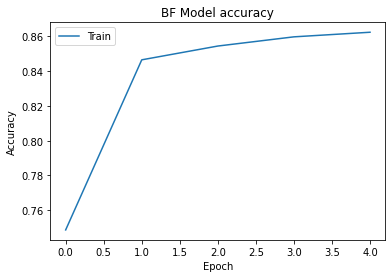

In [ ]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.title('BF Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
y_train_fi = [(1 if y==1 else 0) for y in y_train]
y_train_eq = [(1 if y==2 else 0) for y in y_train]
print(y_train_fi, '\n',y_train_eq)



[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 

Predict category for test data.

In [ ]:
preds = CNN_model.predict(feature_test)
for col in pd.DataFrame(preds).columns:
  print(pd.DataFrame(preds)[col].describe())

count    1.630000e+02
mean     1.192947e-07
std      1.596655e-07
min      2.848347e-09
25%      2.886866e-08
50%      6.372351e-08
75%      1.393266e-07
max      1.101132e-06
Name: 0, dtype: float64


In [ ]:
keras_tokenizer.fit_on_texts(top_sentences_fi)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
sequences_train_fi = keras_tokenizer.texts_to_sequences(top_sentences_fi)
sequences_test_fi = keras_tokenizer.texts_to_sequences(top_sentences_fi_test)
feature_train_fi = pad_sequences(sequences_train_fi, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test_fi = pad_sequences(sequences_test_fi, maxlen=maxlen, dtype=float, padding='post', truncating='post')


In [ ]:
feature_train_fi = np.asarray(feature_train_fi).astype('float32')
feature_test_fi = np.asarray(feature_test_fi).astype('float32')
y_train_fi = np.asarray(y_train_fi).astype('float32')
#y_test = np.asarray(y_test).astype('float32')



In [ ]:
feature_train_fi

array([[  1.,  18.,  72., ...,   0.,   0.,   0.],
       [109.,  68., 128., ...,   0.,   0.,   0.],
       [616.,   1.,  26., ...,   0.,   0.,   0.],
       ...,
       [425., 286.,   8., ...,   0.,   0.,   0.],
       [  1., 898.,   2., ...,   0.,   0.,   0.],
       [131.,  10.,   8., ...,   0.,   0.,   0.]], dtype=float32)

In [ ]:
CNN_history_fi = CNN_model.fit(feature_train_fi, y_train_fi, epochs=5, batch_size=100)

Epoch 1/5
4/4 [==============================] - 2s 450ms/step - loss: 1.3670 - accuracy: 0.7354
Epoch 2/5
4/4 [==============================] - 2s 428ms/step - loss: 1.3474 - accuracy: 0.7434
Epoch 3/5
4/4 [==============================] - 2s 414ms/step - loss: 1.3311 - accuracy: 0.7434
Epoch 4/5
4/4 [==============================] - 2s 446ms/step - loss: 1.3218 - accuracy: 0.7407
Epoch 5/5
4/4 [==============================] - 2s 399ms/step - loss: 1.3026 - accuracy: 0.7434


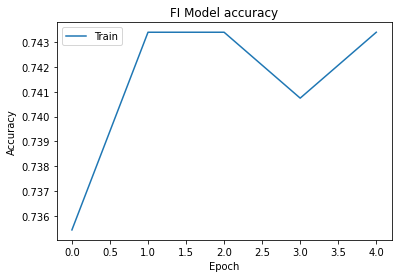

In [ ]:
# Plot training & validation accuracy
plt.plot(CNN_history_fi.history['accuracy'])
plt.title('FI Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
preds_fi = CNN_model.predict(feature_test_fi)
for col in pd.DataFrame(preds_fi).columns:
  print(pd.DataFrame(preds_fi)[col].describe())

count    1.630000e+02
mean     2.002142e-10
std      6.049461e-10
min      3.914399e-12
25%      2.005606e-11
50%      6.630131e-11
75%      2.166889e-10
max      7.147507e-09
Name: 0, dtype: float64


In [ ]:
print(len(y_train_fi), '\n',len(y_train_eq))

378 
 378


In [ ]:
keras_tokenizer.fit_on_texts(top_sentences_eq)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
sequences_train_eq = keras_tokenizer.texts_to_sequences(top_sentences_eq)
sequences_test_eq = keras_tokenizer.texts_to_sequences(top_sentences_eq_test)
feature_train_eq = pad_sequences(sequences_train_eq, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test_eq = pad_sequences(sequences_test_eq, maxlen=maxlen, dtype=float, padding='post', truncating='post')





In [ ]:
feature_train_eq = np.asarray(feature_train_eq).astype('float32')
feature_test_eq = np.asarray(feature_test_eq).astype('float32')
y_train_eq = np.asarray(y_train_eq).astype('float32')
#y_test = np.asarray(y_test).astype('float32')

In [ ]:
CNN_history_eq = CNN_model.fit(feature_train_eq, y_train_eq, epochs=5, batch_size=100)

Epoch 1/5
4/4 [==============================] - 2s 412ms/step - loss: 1.2875 - accuracy: 0.5370
Epoch 2/5
4/4 [==============================] - 2s 403ms/step - loss: 1.2768 - accuracy: 0.5370
Epoch 3/5
4/4 [==============================] - 2s 409ms/step - loss: 1.2662 - accuracy: 0.5344
Epoch 4/5
4/4 [==============================] - 2s 403ms/step - loss: 1.2551 - accuracy: 0.5344
Epoch 5/5
4/4 [==============================] - 2s 404ms/step - loss: 1.2412 - accuracy: 0.5344


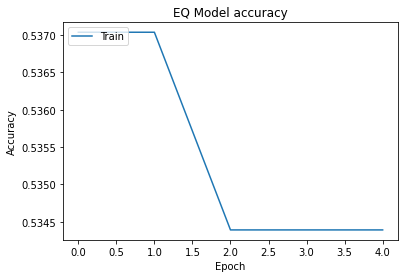

In [ ]:
# Plot training & validation accuracy
plt.plot(CNN_history_eq.history['accuracy'])
plt.title('EQ Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
preds_eq = CNN_model.predict(feature_test_eq)
for col in pd.DataFrame(preds_eq).columns:
  print(pd.DataFrame(preds_eq)[col].describe())

count    1.630000e+02
mean     1.730504e-09
std      3.319950e-09
min      5.984135e-12
25%      2.021287e-10
50%      7.139697e-10
75%      1.575871e-09
max      2.127690e-08
Name: 0, dtype: float64


RNN

In [ ]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [ ]:
RNN_model = create_RNN_model()

In [ ]:
RNN_history = RNN_model.fit(feature_train, y_train_bf, epochs=5, batch_size=16)

Epoch 1/5
24/24 [==============================] - 305s 13s/step - loss: 0.4942 - accuracy: 0.8307
Epoch 2/5
24/24 [==============================] - 290s 12s/step - loss: 0.3836 - accuracy: 0.8651
Epoch 3/5
24/24 [==============================] - 293s 12s/step - loss: 0.3640 - accuracy: 0.8651
Epoch 4/5
24/24 [==============================] - 291s 12s/step - loss: 0.3299 - accuracy: 0.8677
Epoch 5/5
24/24 [==============================] - 292s 12s/step - loss: 0.2749 - accuracy: 0.8915


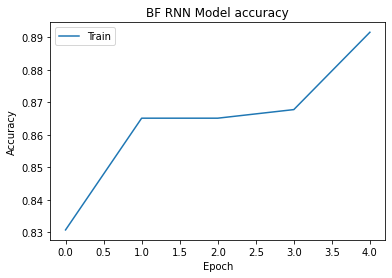

In [ ]:
# Plot training & validation accuracy
plt.plot(RNN_history.history['accuracy'])
plt.title('BF RNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
RNN_preds = RNN_model.predict(feature_test)
for col in pd.DataFrame(RNN_preds).columns:
  print(pd.DataFrame(RNN_preds)[col].describe())

count    163.000000
mean       0.130805
std        0.161927
min        0.022245
25%        0.036814
50%        0.055501
75%        0.144603
max        0.683024
Name: 0, dtype: float64


In [ ]:
RNN_history_fi = RNN_model.fit(feature_train_fi, y_train_fi, epochs=5, batch_size=16)

Epoch 1/5
24/24 [==============================] - 293s 12s/step - loss: 0.6124 - accuracy: 0.7196
Epoch 2/5
 8/24 [=========>....................] - ETA: 3:12 - loss: 0.5208 - accuracy: 0.7734

In [ ]:
plt.plot(RNN_history_fi.history['accuracy'])
plt.title('RNN FI Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
RNN_preds_fi = RNN_model.predict(feature_test_fi)
for col in pd.DataFrame(RNN_preds_fi).columns:
  print(pd.DataFrame(RNN_preds_fi)[col].describe())

In [ ]:
RNN_history_eq = RNN_model.fit(feature_train_eq, y_train_eq, epochs=5, batch_size=16)

In [ ]:
plt.plot(RNN_history_eq.history['accuracy'])
plt.title('RNN EQ Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
RNN_preds_eq = RNN_model.predict(feature_test_eq)
for col in pd.DataFrame(RNN_preds_eq).columns:
  print(pd.DataFrame(RNN_preds_eq)[col].describe())

Outlier detection: Calculate the distance to the three knowledge bases.

In [ ]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_score(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
            # print(sentence_barycentre)
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [sum((sentence_barycentre-word2vec[key_word])**2) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    # sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    # top_sentences = sentences[:num_sent]
    return sentence_scores

In [ ]:
scores = outlier_summary_df.apply(lambda x : extract_sentence_score(x['summary'], knowledge_base_bf, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [ ]:
scores

In [ ]:
normal_score = df_merge.apply(lambda x : extract_sentence_score(x['summary'], knowledge_base_bf, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [ ]:
normal_score

The end.